Using the cleaned version of the CIC-IDS2017 dataset

In [29]:
!pip install fastai
!pip install pyarrow

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
dfps = []
for dirname, _, filenames in os.walk('/project_ghent/datasets/clean-ids-collection/cic-ids2017/clean'):
# for dirname, _, filenames in os.walk('/project_ghent/datasets/clean-ids-collection/cse-cic-ids2018/clean'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps.append(dfp)
            print(dfp)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/project_ghent/datasets/clean-ids-collection/cic-ids2017/clean/cicids2017.parquet
/project_ghent/datasets/clean-ids-collection/cic-ids2017/clean/Infiltration-Thursday-WorkingHours-Afternoon.pcap_ISCX.parquet
/project_ghent/datasets/clean-ids-collection/cic-ids2017/clean/DDoS-Friday-WorkingHours-Afternoon.pcap_ISCX.parquet
/project_ghent/datasets/clean-ids-collection/cic-ids2017/clean/WebAttacks-Thursday-WorkingHours-Morning.pcap_ISCX.parquet
/project_ghent/datasets/clean-ids-collection/cic-ids2017/clean/Benign-Monday-WorkingHours.pcap_ISCX.parquet
/project_ghent/datasets/clean-ids-collection/cic-ids2017/clean/Portscan-Friday-WorkingHours-Afternoon.pcap_ISCX.parquet
/project_ghent/datasets/clean-ids-collection/cic-ids2017/clean/Botnet-Friday-WorkingHours-Morning.pcap_ISCX.parquet
/project_ghent/datasets/clean-ids-collection/cic-ids2017/clean/Bruteforce-Tuesday-WorkingHours.pcap_ISCX.parquet
/project_ghent/datasets/clean-ids-collection/cic-ids2017/clean/DoS-Wednesday-WorkingHours.pcap_IS

Importing the necesary libraries

In [31]:
from fastai.imports import *
from fastai.vision.all import *
from sklearn.preprocessing import MinMaxScaler

we will throw away Benign monday and work with the benign data in the rest of the dataset

In [32]:
dfps = [dfp for dfp in dfps if not 'Benign' in dfp] #remove Benign monday

In [33]:
df = pd.concat([pd.read_parquet(dfp) for dfp in dfps], ignore_index=True)

In [34]:
df.head(2)

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,12,0,6,6,6.0,0.0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,1,2,0,12,0,6,6,6.0,0.0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


make label binary

In [35]:
df.loc[df['Label'] != 'Benign', 'Label'] = 1
df.loc[df['Label'] == 'Benign', 'Label'] = 0
print(df['Label'].value_counts())
df['Label'] = df['Label'].astype(dtype=np.int32)

0    3381067
1     672766
Name: Label, dtype: int64


splitting data helper function

In [36]:
def xs_y(df_, targ): 
    if not isinstance(targ, list):
        xs = df_[df_.columns.difference([targ])].copy() #splot target from data
    else:
        xs = df_[df_.columns.difference(targ)].copy()
    y = df_[targ].copy()
    return xs, y

In [37]:
training_set = df.sample(frac=0.2, replace=False, random_state=42)
testing_set = df.drop(index=training_set.index)
training_set.shape, testing_set.shape

((810767, 67), (3243066, 67))

In [38]:
training_set=training_set.sample(n=5000)
testing_set=testing_set.sample(n=5000)
training_set.shape, testing_set.shape

((5000, 67), (5000, 67))

In [39]:
X_train, y_train = xs_y(training_set, targ="Label")
X_test, y_test = xs_y(testing_set, targ="Label")

I'll try to represent each flow with an image, for this to succeed I need to scale every feture to a range between 0 en 255

In [40]:
#example for 1 flow
df_norm=X_train.copy()

In [41]:
df_norm.columns

Index(['ACK Flag Count', 'Active Max', 'Active Mean', 'Active Min',
       'Active Std', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size',
       'Avg Packet Size', 'Bwd Header Length', 'Bwd IAT Max', 'Bwd IAT Mean',
       'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Total', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Min',
       'Bwd Packet Length Std', 'Bwd Packets Length Total', 'Bwd Packets/s',
       'Down/Up Ratio', 'ECE Flag Count', 'FIN Flag Count', 'Flow Bytes/s',
       'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min',
       'Flow IAT Std', 'Flow Packets/s', 'Fwd Act Data Packets',
       'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min',
       'Fwd IAT Std', 'Fwd IAT Total', 'Fwd PSH Flags',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Min', 'Fwd Packet Length Std',
       'Fwd Packets Length Total', 'Fwd Packets/s', 'Fwd Seg Size Min',
       'Idle Max', 'Idle Mean', 'Idle Mi

apply min max normalisation

In [42]:
scaler=MinMaxScaler((0,255))
scaled_features=scaler.fit_transform(df_norm)

In [43]:
df=pd.DataFrame(scaled_features,columns=df_norm.columns)

In [44]:
df

,ACK Flag Count,Active Max,Active Mean,Active Min,Active Std,Avg Bwd Segment Size,Avg Fwd Segment Size,Avg Packet Size,Bwd Header Length,Bwd IAT Max,...,Packet Length Variance,RST Flag Count,SYN Flag Count,Subflow Bwd Bytes,Subflow Bwd Packets,Subflow Fwd Bytes,Subflow Fwd Packets,Total Backward Packets,Total Fwd Packets,URG Flag Count
0,0.0,0.000000,0.000000,0.000000,0.000000,32.575640,10.831090,29.044693,1.656822,0.114608,...,2.696270,0.0,0.0,0.310142,1.004431,1.588823,2.409449,1.004431,2.409449,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,10.221102,4.126850,9.816405,0.401654,0.000008,...,0.040378,0.0,0.0,0.024328,0.251108,0.186268,0.602362,0.251108,0.602362,0.0
2,255.0,18.679410,3.437600,0.189053,62.622923,44.173559,51.133155,67.799876,16.392499,21.405773,...,1.526418,0.0,255.0,6.518719,15.568685,71.545821,24.696850,15.568685,24.696850,0.0
3,0.0,0.438855,0.165556,0.138019,0.925913,53.157971,1.792232,45.775732,4.870053,21.394336,...,8.511407,0.0,0.0,1.518301,3.013294,0.505585,4.818898,3.013294,4.818898,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,7.451513,5.109433,12.289385,0.125517,0.000000,...,0.016473,0.0,0.0,0.008868,0.125554,0.057654,0.000000,0.125554,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,255.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200827,0.000000,...,0.000000,0.0,0.0,0.000000,0.125554,0.000000,0.000000,0.125554,0.000000,0.0
4996,255.0,0.003750,0.003750,0.003750,0.000000,127.434057,4.409342,96.713165,1.255168,0.297723,...,34.904702,0.0,0.0,0.909945,0.753323,0.398037,1.405512,0.753323,1.405512,0.0
4997,255.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200827,0.000000,...,0.000000,0.0,0.0,0.000000,0.125554,0.000000,0.000000,0.125554,0.000000,255.0
4998,255.0,0.000000,0.000000,0.000000,0.000000,0.395656,195.174918,223.021181,0.125517,0.000000,...,12.644505,0.0,0.0,0.000471,0.125554,63.867804,5.622047,0.125554,5.622047,0.0


our numpy array has 77 elements, we will make a gray scaled picture with dimensions 9x9 and add some black pixels for padding

here the process is worked out for a single flow

In [45]:
np_image=np.concatenate((df.iloc[0],[0]*15)).reshape(9,9)
np_image.shape

(9, 9)

In [46]:
im=PILImage.create(np_image.astype(np.uint8))
im

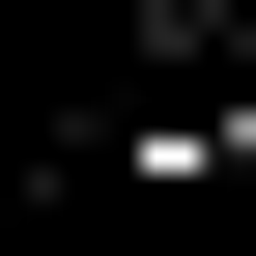

In [47]:
im=im.resize((256,256))
im

In [48]:
# dest.mkdir(exist_ok=True, parents=True)
# im.save(dest/"0.jpg")

we will now do this for each packet flow

In [49]:
path = Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/train')

In [50]:
labels=["benign","malign"]

In [51]:
def flow_to_image(i):
    np_image=np.concatenate((df.iloc[i],[0]*15)).reshape(9,9)
    im=PILImage.create(np_image.astype(np.uint8))
#     im=im.resize((256,256))
    #save the image in correct folder
    dest=(path/labels[y_train.iloc[i]]) #dest will be flow_images/benign or flow_images/malign
    dest.mkdir(exist_ok=True, parents=True)
    im.save(dest/f"{i}.jpg")

In [52]:
parallel(f=flow_to_image, 
                  items=range(df.shape[0]), n_workers=os.cpu_count(), threadpool=False, progress=True)

(#5000) [None,None,None,None,None,None,None,None,None,None...]

In [53]:
df_norm=X_test.copy()
scaled_features=scaler.fit_transform(df_norm)
df=pd.DataFrame(scaled_features,columns=df_norm.columns)

In [54]:
path = Path('/project_ghent/raman/cic-ids2017/subset-5000/flow_images/test')

In [55]:
def flow_to_image(i):
    np_image=np.concatenate((df.iloc[i],[0]*15)).reshape(9,9)
    im=PILImage.create(np_image.astype(np.uint8))
    #save the image in correct folder
    dest=(path/labels[y_test.iloc[i]]) #dest will be flow_images/benign or flow_images/malign
    dest.mkdir(exist_ok=True, parents=True)
    im.save(dest/f"{i}.jpg")

In [56]:
parallel(f=flow_to_image, 
                  items=range(df.shape[0]), n_workers=os.cpu_count(), threadpool=False, progress=True)

(#5000) [None,None,None,None,None,None,None,None,None,None...]